<a href="https://colab.research.google.com/github/PozzaMarco/VCS_Pix2Pix_Implementation/blob/main/VCS_P2P_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image to Image Translation with Pix2Pix GANs ([references](https://machinelearningmastery.com/a-gentle-introduction-to-pix2pix-generative-adversarial-network/))

# Install packages

In [ ]:
!pip3 install image-similarity-measures

#Imports

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset

import torchvision
import torchvision.utils as vutils
import torchvision.datasets as datasets
from torchvision.utils import save_image
import torchvision.transforms as transformers

from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import numpy as np

from tqdm import tqdm

import os
from PIL import Image
import albumentations as A
from albumentations.pytorch import ToTensor
from google.colab import files
import shutil

import skimage
from image_similarity_measures.quality_metrics import ssim, psnr, fsim

# Model save/load options
Different options that allows me to select the dataset to load, decide to save/load previous weights' checkpoints and change the name of the folders where to save all the reconstructed images.


In [ ]:
LOAD_MODEL = True
SAVE_MODEL = True
TYPE = "extended_dataset"
DATASET_NAME = "masked_35_15_joint"
SAVING_FOLDER = "drive/MyDrive/VCS_datasets/"+TYPE+"/"+DATASET_NAME+"/checkpoints/"
DATASET_FOLDER = "drive/MyDrive/VCS_datasets/"+TYPE+"/"+DATASET_NAME+"/data/"
CHECKPOINT_GEN = SAVING_FOLDER +"gen_"+DATASET_NAME+".pth.tar"
CHECKPOINT_DISC = SAVING_FOLDER + "disc_"+DATASET_NAME+".pth.tar"

#Hyperparameters
Hyperparameters that could be set to change the training process.

In [ ]:
# Hyperparameters
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
LEARNING_RATE = 2e-4
BATCH_SIZE = 64
IMAGE_SIZE = 256
CHANNELS_IMG = 3
NUM_WORKERS = 2
L1_LAMBDA = 150
NUM_EPOCHS = 100
BETA1 = 0.5
BETA2 = 0.999

# Utils
Utility function used for the whole project.

In [ ]:
def delete_folder(folder_num):
  if folder_num == 0:
    shutil.rmtree('/content/evaluation')
  elif folder_num == 1:
    shutil.rmtree('/content/generated')
  else:
    print("0: evaluation, 1: generated")

def save_checkpoint(model, optimizer, filename="my_checkpoint.pth.tar"):
  print("=> Saving checkpoint")
  checkpoint = {
      "state_dict": model.state_dict(),
      "optimizer": optimizer.state_dict(),
  }
  torch.save(checkpoint, filename)

def load_checkpoint(checkpoint_file, model, optimizer, lr):
  print("=> Loading checkpoint")
  checkpoint = torch.load(checkpoint_file, map_location = DEVICE)
  model.load_state_dict(checkpoint["state_dict"])
  optimizer.load_state_dict(checkpoint["optimizer"])

  for param_group in optimizer.param_groups:
    param_group["lr"] = lr

def print_metrics(true_image, test_image):
  true_image = true_image.cpu().squeeze(0).permute(1, 2, 0).numpy()
  test_image = test_image.cpu().squeeze(0).permute(1, 2, 0).numpy()
  
  #psnr_score = skimage.metrics.peak_signal_noise_ratio(true_image, test_image)
  ssim_score, grad= skimage.metrics.structural_similarity(true_image, test_image,
                                               multichannel=True, full=True)
  psnr_score = psnr(true_image, test_image)
  fsim_score = fsim(true_image, test_image)          
                                 
  print("PSNR: %2f --- SSIM: %2f --- FSIM: %2f" % (psnr_score, ssim_score, fsim_score))
  return psnr_score, ssim_score, fsim_score
  
def save_some_examples(gen, val_loader, epoch, folder):
  x, y = next(iter(val_loader))
  x = x.to(DEVICE)
  y = y.to(DEVICE)

  x = np.swapaxes(x, 1,3)
  x = x.float()/255.0

  y = np.swapaxes(y, 1,3)
  y = y.float()/255.0
  
  
  if os.path.isdir('/content/'+folder) == False:
    os.mkdir('/content/'+folder)

  gen.eval()
  
  with torch.no_grad():
    y_fake = gen(x)

    """
    y_fake_save = y_fake * 0.5 + 0.5
    x_save = x * 0.5 + 0.5
    y_save = y * 0.5 + 0.5
    """
    
    y_fake_save = y_fake 
    x_save = x
    y_save = y
    
    _, ssim, _= print_metrics(y, y_fake_save)

    save_image(y_fake_save, folder + f"/y_gen_{epoch}.png")
    save_image(x_save, folder + f"/input_{epoch}.png")

    if epoch == 0:
      save_image(y_save, folder + f"/label_{epoch}.png")
    
  
  gen.train()
  return ssim

def generate_samples(gen, val_loader, folder):
  loop = tqdm(val_loader, leave=True)

  orig_psnr = []
  orig_ssim = []
  orig_fsim = []

  gen_psnr = []
  gen_ssim = []
  gen_fsim = []

  samples = 0
  op = 0
  ors = 0
  of = 0
  gp = 0
  gs = 0
  gf = 0

  for idx, (x, y) in enumerate(val_loader):
    if samples == 500:
      break
    else:
      samples += 1
      
      x = x.to(DEVICE)
      y = y.to(DEVICE)
      
      x = np.swapaxes(x, 1,3)
      x = x.float()/255.0

      y = np.swapaxes(y, 1,3)
      y = y.float()/255.0
    
    
      if os.path.isdir('/content/'+folder) == False:
        os.mkdir('/content/'+folder)

      gen.eval()
      
      with torch.no_grad():
        y_fake = gen(x)
        y_fake_save = y_fake 
        x_save = x
        y_save = y

        print(idx)
        op, ors, of = print_metrics(x, y)
        orig_psnr.append(op)
        orig_ssim.append(ors)
        orig_fsim.append(of)

        gp, gs, gf = print_metrics(y, y_fake_save)
        gen_psnr.append(gp)
        gen_ssim.append(gs)
        gen_fsim.append(gf)
    
        save_image(y_fake_save, folder + f"/y_gen_{idx}.png")
        save_image(x_save, folder + f"/input_{idx}.png")
        save_image(y_save, folder + f"/label_{idx}.png")
        
      gen.train()


# Dataset
Load of the masked Caltech Birds dataset that I have created with a custom procedure that allows me to select the size of the masking patches and the extension over the whole image.

In [ ]:
class CaltechDataset(Dataset):
  def __init__(self, root_dir):
    self.root_dir = root_dir
    self.list_files = os.listdir(self.root_dir)

    self.both_transform = A.Compose(
        [
         A.Resize(width = 256, height = 256),
        ], 
        additional_targets = {"image0: image"},
    )

    self.transform_only_input = A.Compose(
        [
         A.RandomBrightnessContrast(),
         A.HueSaturationValue(),
         A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5], max_pixel_value=255.0),
         ToTensor(),
        ]
    )

    self.tranform_only_mask = A.Compose(
        [
         A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5], max_pixel_value=255.0),
         ToTensor(),
        ]
    )

    #print(self.list_files)
  
  def __len__(self):
    return len(self.list_files)
  
  def __getitem__(self, index):
    img_file = self.list_files[index]
    img_path = os.path.join(self.root_dir, img_file)
    image = np.array(Image.open(img_path))

    target_image = image[:, :250, :]  # since the image is one we need to cut it in half
    masked_image = image[:, 250:, :]
    
    augmentations = self.both_transform(image = masked_image)
    masked_image = self.both_transform(image = masked_image)["image"]
    target_image = self.both_transform(image = target_image)["image"]

    """
    masked_image = self.transform_only_input(image = masked_image)["image"]
    target_image = self.transform_only_target(image = target_image)["image"]
    """
    return masked_image, target_image

(256, 256, 3)
(256, 256, 3)


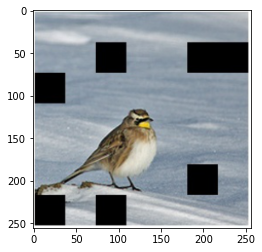

In [ ]:
train_dataset = CaltechDataset(root_dir=DATASET_FOLDER+"train")
x, y= next(iter(train_dataset))
print(x.shape)
print(y.shape)

plt.imshow(x)
plt.show()

# Model implementation
Implementation of the vanilla Pix2Pix model divided in:
- Discriminator;
- Generator.

The implementation follows, among different research papers, this two videos:
- Paper presentation: [video](https://www.youtube.com/watch?v=9SGs4Nm0VR4)
- Model presentation and implementation: [video](https://www.youtube.com/watch?v=SuddDSqGRzg&t=2s)


## Discriminator
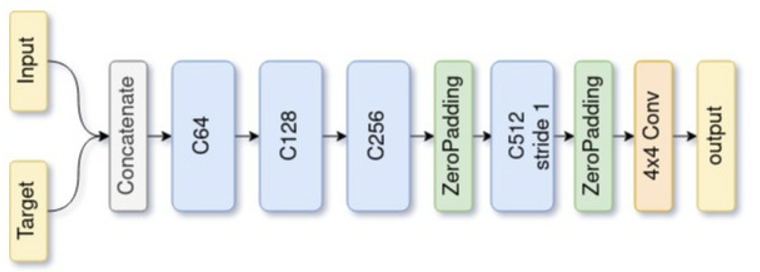

In [ ]:
# Single discriminator block
class CNNBlock(nn.Module):
  def __init__(self, in_channels, out_channels, stride = 2):
    super().__init__()
    self.conv = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size= 4, stride = stride, bias = False, padding_mode="reflect"),
        nn.BatchNorm2d(out_channels),
        nn.LeakyReLU(0.2),
    )
  def forward(self, x):
    return self.conv(x)

In [ ]:
# Discriminator class
class Discriminator(nn.Module):
  def __init__(self, in_channels = 3, features = [64, 128, 256, 512]):
    super().__init__()
    self.initial = nn.Sequential(
        nn.Conv2d(in_channels * 2, features[0], kernel_size=4, stride=2, padding=1, padding_mode="reflect"),
        nn.LeakyReLU(0.2),
    )
    layers = []
    in_channels = features[0]
    for feature in features[1:]:
      layers.append(
          CNNBlock(in_channels, feature, stride=1 if feature == features[-1] else 2)
      )
      in_channels = feature
    
    layers.append(
        nn.Conv2d(
            in_channels, 1, kernel_size = 4, padding=1, padding_mode="reflect"
        )
    )
    
    self.model = nn.Sequential(*layers) # unpack the layers array and create a correct architecture
  
  def forward(self, x, y):
    x = torch.cat([x,y], dim = 1) # concatenate the input and the target in one single image
    x = self.initial(x)
    return self.model(x)

In [ ]:
def test_discriminator():
  x = torch.randn((1,3, 256, 256))
  y = torch.randn((1,3, 256, 256))
  model = Discriminator()
  preds = model(x,y)
  print(preds.shape)

test_discriminator()

torch.Size([1, 1, 26, 26])


## Generator
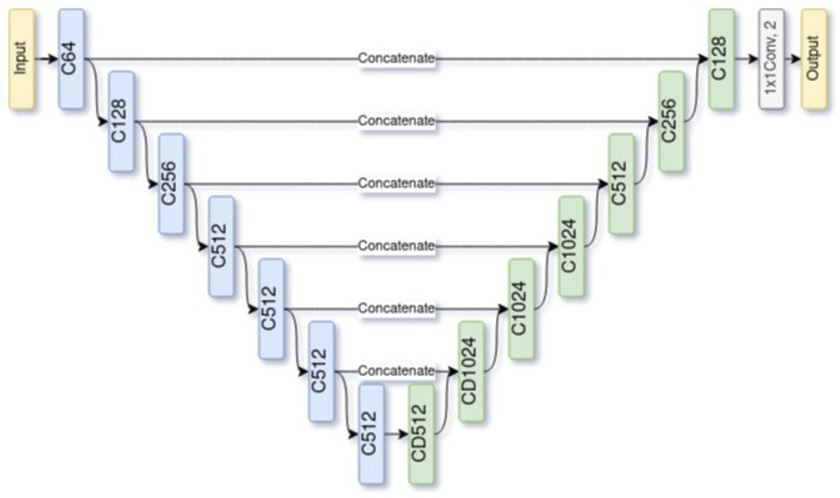

In [ ]:
# Create single generator block
class Block(nn.Module):
  def __init__(self,in_channels, out_channels, down=True, act="relu", use_dropout=False):
    super().__init__()
    self.conv = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size = 4, stride = 2, padding = 1, bias=False, padding_mode="reflect")
        if down
        else nn.ConvTranspose2d(in_channels, out_channels, kernel_size = 4, stride = 2, padding = 1, bias=False),
        nn.BatchNorm2d(out_channels),
        nn.ReLU() if act=="relu" else nn.LeakyReLU(0.2),
    )
    self.use_dropout = use_dropout
    self.dropout = nn.Dropout(0.5)
  
  def forward(self, x):
    x = self.conv(x)
    return self.dropout(x) if self.use_dropout else x

In [ ]:
#Create Generator
class Generator(nn.Module):
  def __init__(self, in_channels = 3, features = 64):
    super().__init__()
    self.initial_down = nn.Sequential(
        nn.Conv2d(in_channels, features, kernel_size = 4, stride = 2, padding = 1, padding_mode="reflect"),
        nn.LeakyReLU(0.2),
    ) #128

    self.down1 = Block(features, features*2, down=True, act="leaky", use_dropout=False) #64
    self.down2 = Block(features*2, features*4, down=True, act="leaky", use_dropout=False) #32
    self.down3 = Block(features*4, features*8, down=True, act="leaky", use_dropout=False) #16
    self.down4 = Block(features*8, features*8, down=True, act="leaky", use_dropout=False) #8
    self.down5 = Block(features*8, features*8, down=True, act="leaky", use_dropout=False) #4
    self.down6 = Block(features*8, features*8, down=True, act="leaky", use_dropout=False) #2

    self.bottleneck = nn.Sequential(
        nn.Conv2d(features*8, features*8, kernel_size = 4, stride = 2, padding = 1, padding_mode="reflect"),
        nn.ReLU(),
    ) #1x1

    self.up1 = Block(features*8, features*8, down=False, act="relu", use_dropout=True)
    self.up2 = Block(features*8*2, features*8, down=False, act="relu", use_dropout=True)
    self.up3 = Block(features*8*2, features*8, down=False, act="relu", use_dropout=True)
    self.up4 = Block(features*8*2, features*8, down=False, act="relu", use_dropout=False)
    self.up5 = Block(features*8*2, features*4, down=False, act="relu", use_dropout=False)
    self.up6 = Block(features*4*2, features*2, down=False, act="relu", use_dropout=False)
    self.up7 = Block(features*2*2, features, down=False, act="relu", use_dropout=False)

    self.final_up = nn.Sequential(
        nn.ConvTranspose2d(features*2, in_channels, kernel_size = 4, stride = 2, padding = 1),
        nn.Tanh(),
    )
  #To better understand this look to the architecture image of U-NET
  def forward(self, x):
    d1 = self.initial_down(x)
    d2 = self.down1(d1)
    d3 = self.down2(d2)
    d4 = self.down3(d3)
    d5 = self.down4(d4)
    d6 = self.down5(d5)
    d7 = self.down6(d6)
    
    bottleneck = self.bottleneck(d7)

    up1 = self.up1(bottleneck)
    up2 = self.up2(torch.cat([up1, d7], 1))
    up3 = self.up3(torch.cat([up2, d6], 1))
    up4 = self.up4(torch.cat([up3, d5], 1))
    up5 = self.up5(torch.cat([up4, d4], 1))
    up6 = self.up6(torch.cat([up5, d3], 1))
    up7 = self.up7(torch.cat([up6, d2], 1))
    return self.final_up(torch.cat([up7, d1], 1))

In [ ]:
def test_generator():
  x = torch.randn((1, 3, 256, 256))
  model = Generator(in_channels = 3, features = 64)
  preds = model(x)
  print(preds.shape)

test_generator()

torch.Size([1, 3, 256, 256])


# Training 
Training procedure with early stopping.
The hyperparameters are set at the beginning of the notebook.

In [ ]:
Tdef train_fn(disc, gen, loader, opt_disc, opt_gen, l1, bce, g_scaler, d_scaler):
  loop = tqdm(loader, leave=True)
  
  for idx, (x, y) in enumerate(loop):
    x = x.to(DEVICE)
    y = y.to(DEVICE)
    
    x = np.swapaxes(x, 1,3)
    x = x.float()/255.0

    y = np.swapaxes(y, 1,3)
    y = y.float()/255.0
    
    #Train Discriminator
    with torch.cuda.amp.autocast():
      y_fake = gen(x)
      D_real = disc(x,y)
      D_fake = disc(x, y_fake.detach())
      D_real_loss = bce(D_real, torch.ones_like(D_real))
      D_fake_loss = bce(D_fake, torch.zeros_like(D_fake))
      D_loss = (D_real_loss + D_fake_loss) / 2

    opt_disc.zero_grad()
    d_scaler.scale(D_loss).backward()
    d_scaler.step(opt_disc)
    d_scaler.update()

    #Train Generator
    with torch.cuda.amp.autocast():
      D_fake = disc(x, y_fake)
      G_fake_loss = bce(D_fake, torch.ones_like(D_fake))
      L1 = l1(y_fake, y) * L1_LAMBDA
      G_loss = G_fake_loss + L1

    opt_gen.zero_grad()
    g_scaler.scale(G_loss).backward()
    g_scaler.step(opt_gen)
    g_scaler.update()

In [ ]:
disc = Discriminator(in_channels = 3).to(DEVICE)
gen = Generator(in_channels = 3).to(DEVICE)
opt_disc = optim.Adam(disc.parameters(), lr = LEARNING_RATE, betas = (BETA1, BETA2))
opt_gen = optim.Adam(gen.parameters(), lr = LEARNING_RATE, betas = (BETA1, BETA2))
BCE = nn.BCEWithLogitsLoss()
L1_LOSS = nn.L1Loss()

if LOAD_MODEL:
  load_checkpoint(CHECKPOINT_GEN, gen, opt_gen, LEARNING_RATE)
  load_checkpoint(CHECKPOINT_DISC, disc, opt_disc, LEARNING_RATE)

g_scaler = torch.cuda.amp.GradScaler()
d_scaler = torch.cuda.amp.GradScaler()

train_dataset = CaltechDataset(root_dir=DATASET_FOLDER+"train")
train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, num_workers = NUM_WORKERS)

val_dataset = CaltechDataset(root_dir=DATASET_FOLDER+"val")
val_loader = DataLoader(val_dataset, batch_size = 1)

best_ssim = -1
saved_epochs = 0
early_stopping_count = 0

for epoch in range(NUM_EPOCHS):
  print(f"EPOCH:  {epoch}")
  train_fn(disc, gen, train_loader, opt_disc, opt_gen, L1_LOSS, BCE, g_scaler, d_scaler)
  
  new_ssim = save_some_examples(gen, val_loader, epoch, folder = "evaluation")

  if SAVE_MODEL and new_ssim > best_ssim:
    best_ssim = new_ssim
    saved_epochs += 1
    save_checkpoint(gen, opt_gen, filename=CHECKPOINT_GEN)
    save_checkpoint(disc, opt_disc, filename=CHECKPOINT_DISC)

    early_stopping_count = 0

  else if early_stopping_count == 5:
    epoch = NUM_EPOCHS 
  
  else:
    early_stopping_count += 1
  
print(f"Saved {saved_epochs} out of {NUM_EPOCHS}")

# Generate samples
Reconstruction of the images using the validation set to see the model's performances and reconstruction capabilities.

In [ ]:
generate_samples(gen, val_loader, folder = "generated")

# Zip Files
Create zip file to easily download the reconstructed images.

In [ ]:
!zip -r /content/3515_results.zip /content/generated

#Delete folders

Delete folders to clean the workspace and start with new training experiments.
Parameters:
 - **0**: delete the *evaluation* folder that contains the images reconstructed under training;
 - **1**: delete the *generated* folder that contains the images reconstructed after training to test the model capabilities;

In [ ]:
delete_folder(0)